## Download the Kaggle Dataset
[H&M Personalized Fashion Recommendations](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/overview)

In [1]:
# Install opendatasets
!pip -q install opendatasets
import opendatasets as od

import os
import random
import matplotlib.pyplot as plt
from PIL import Image

1. Kaggle username can be found in the **Account** tab of the **Your Profile** section.
2. Under the **Account** tab of the **Your Profile** section and click on **Create New API Token**. This will download a kaggle.json file.

In [ ]:
od.download("https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/data/transactions_train.csv", force=True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  anishputhuraya


Your Kaggle Key:

  ································


  3%|▎         | 989M/28.7G [00:23<15:12, 32.6MB/s]   

In [9]:
!ls -lah h-and-m-personalized-fashion-recommendations

total 3.8G
drwxr-xr-x  3 jupyter jupyter 4.0K Oct  2 23:17 .
drwxr-xr-x  4 jupyter jupyter 4.0K Oct  2 22:09 ..
-rw-r--r--  1 jupyter jupyter  35M Oct  2 22:07 articles.csv
-rw-r--r--  1 jupyter jupyter 198M Oct  2 22:07 customers.csv
drwxr-xr-x 88 jupyter jupyter 4.0K Oct  2 23:14 images
-rw-r--r--  1 jupyter jupyter 258M Oct  2 23:14 sample_submission.csv
-rw-r--r--  1 jupyter jupyter 3.3G Oct  2 23:17 transactions_train.csv


### Copy the data files (*.csv) to your bucket:
Modify the bucket name to yours...

In [57]:
!gsutil -m cp h-and-m-personalized-fashion-recommendations/*.csv gs://ba775-ap/data/h_and_m

Copying file://h-and-m-personalized-fashion-recommendations/articles.csv [Content-Type=text/csv]...
Copying file://h-and-m-personalized-fashion-recommendations/customers.csv [Content-Type=text/csv]...
Copying file://h-and-m-personalized-fashion-recommendations/sample_submission.csv [Content-Type=text/csv]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

Copy

In [3]:
# If you weren't able to download the data from Kaggle you can uncomment the line below and update your bucket name:
!gsutil -m cp gs://ba-775-public/data/h_and_m/transactions_train.csv gs://ba775-ap/data/h_and_m/
!gsutil -m cp gs://ba-775-public/data/h_and_m/articles.csv gs://ba775-ap/data/h_and_m/
!gsutil -m cp gs://ba-775-public/data/h_and_m/customers.csv gs://ba775-ap/data/h_and_m/

Copying gs://ba-775-public/data/h_and_m/transactions_train.csv [Content-Type=text/csv]...
/ [1/1 files][  3.2 GiB/  3.2 GiB] 100% Done                                    
Operation completed over 1 objects/3.2 GiB.                                      
Copying gs://ba-775-public/data/h_and_m/articles.csv [Content-Type=text/csv]...
/ [1/1 files][ 34.4 MiB/ 34.4 MiB] 100% Done                                    
Operation completed over 1 objects/34.4 MiB.                                     
Copying gs://ba-775-public/data/h_and_m/customers.csv [Content-Type=text/csv]...
/ [1/1 files][197.5 MiB/197.5 MiB] 100% Done                                    
Operation completed over 1 objects/197.5 MiB.                                    


Replace `ba-775-public` with your own bucket name:

In [58]:
!gsutil ls gs://ba-775-public/data/h_and_m/

gs://ba-775-public/data/h_and_m/
gs://ba-775-public/data/h_and_m/articles.csv
gs://ba-775-public/data/h_and_m/customers.csv
gs://ba-775-public/data/h_and_m/sample_submission.csv
gs://ba-775-public/data/h_and_m/transactions_train.csv


Create a new dataset (schema) called `h_and_m`:

In [4]:
%%bigquery
CREATE SCHEMA IF NOT EXISTS h_and_m

Query complete after 0.01s: 100%|██████████| 1/1 [00:00<00:00, 217.36query/s] 


Empty DataFrame
Columns: []
Index: []

Create 3 tables from the 3 csv files: `articles.csv`, `customers.csv`, and `transactions_train.csv`. Make sure to replace `ba-775-public` with your own bucket name.

In [5]:
%%bigquery
LOAD DATA OVERWRITE h_and_m.articles
FROM FILES (
  format = 'CSV',
  uris = ['gs://ba-775-public/data/h_and_m/articles.csv'])


Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 394.20query/s]                          


Empty DataFrame
Columns: []
Index: []

In [6]:
%%bigquery
LOAD DATA OVERWRITE h_and_m.customers
FROM FILES (
  format = 'CSV',
  uris = ['gs://ba-775-public/data/h_and_m/customers.csv'])


Query complete after 0.01s: 100%|██████████| 1/1 [00:00<00:00, 212.63query/s]                          


Empty DataFrame
Columns: []
Index: []

We'll save `transactions_train.csv` as `transactions`:

In [7]:
%%bigquery
LOAD DATA OVERWRITE h_and_m.transactions_train
FROM FILES (
  format = 'CSV',
  uris = ['gs://ba-775-public/data/h_and_m/transactions_train.csv'])


Query complete after 0.01s: 100%|██████████| 3/3 [00:00<00:00, 600.50query/s]                         


Empty DataFrame
Columns: []
Index: []

Since `transactions` table has over 31 million rows (and almost 3GB) we will create a random sample of approximately 1% of this table and work with that during our initial exploration to save cost and improve performance:

In [66]:
%%bigquery


Query complete after 0.00s: 100%|██████████| 3/3 [00:00<00:00, 1384.72query/s]                        


Empty DataFrame
Columns: []
Index: []

## Exploring the `articles` table

In [68]:
%%bigquery
SELECT * FROM h_and_m.articles LIMIT 3

Downloading: 100%|██████████| 3/3 [00:01<00:00,  2.36rows/s]


article_id  product_code     prod_name  product_type_no product_type_name  \
0   448831026        448831     Tom Solid               59   Swimwear bottom   
1   510264001        510264  Carl covered               59   Swimwear bottom   
2   566941026        566941     Tom solid               59   Swimwear bottom   

  product_group_name  graphical_appearance_no graphical_appearance_name  \
0           Swimwear                  1010016                     Solid   
1           Swimwear                  1010005           Colour blocking   
2           Swimwear                  1010016                     Solid   

   colour_group_code colour_group_name  ...  department_name index_code  \
0                 63       Dark Purple  ...         Swimwear          F   
1                 63       Dark Purple  ...         Swimwear          F   
2                 20      Other Yellow  ...         Swimwear          F   

   index_name index_group_no  index_group_name section_no   section_name  \
0    Menswear              3          Menswear         26  Men Underwear   
1    Menswear              3          Menswear         26  Men Underwear   
2    Menswear              3          Menswear         26  Men Underwear   

  garment_group_no  garment_group_name  \
0             1018            Swimwear   
1             1018            Swimwear   
2             1018            Swimwear   

                                         detail_desc  
0  Short swim shorts with an elasticated drawstri...  
1  Short swim shorts with an elasticated drawstri...  
2  Swim shorts in woven fabric with an elasticate...  

[3 rows x 25 columns]

###  Display some of the images

Total number of files in images:  96491


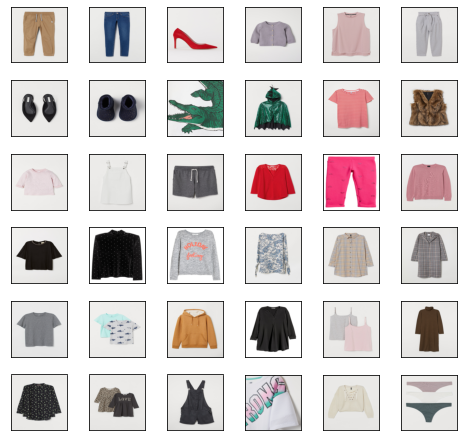

In [8]:
filenames = []
for path, subdirs, files in os.walk('h-and-m-personalized-fashion-recommendations/images'):
    for name in files:
        filenames.append(os.path.join(path, name))
print('Total number of files in images: ', len(filenames))

random.seed(10)
sample_images = random.sample(filenames, 36)

fig, axes = plt.subplots(6, 6, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.4))

for i, ax in enumerate(axes.flat):
    ax.imshow(Image.open(sample_images[i]).resize((180, 180)))
    #ax.set_title(sample_images[i]) 

How many unique articles/products/etc are in this table?

In [11]:
%%bigquery
SELECT COUNT(DISTINCT article_id) FROM h_and_m.articles

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.11s/rows]


f0_
0  105542

Can you investigate and figure out what the difference between `article_id` and `product_code` is?

In [17]:
%%bigquery
SELECT
    prod_name,
    COUNT(DISTINCT article_id) AS count_articles,
    COUNT(DISTINCT graphical_appearance_name) AS distinct_appearances,
    COUNT(DISTINCT colour_group_name) AS distinct_colors
FROM
    h_and_m.articles
GROUP BY
    prod_name
ORDER BY
    count_articles DESC

Downloading: 100%|██████████| 45875/45875 [00:00<00:00, 48883.28rows/s]


prod_name  count_articles  distinct_appearances  \
0                    Dragonfly dress              98                     5   
1                           Mike tee              72                     3   
2               Wow printed tee 6.99              70                     2   
3                            1pk Fun              55                     3   
4              TP Paddington Sweater              54                     6   
...                              ...             ...                   ...   
45870               HW Football body               1                     1   
45871                 Printed Jogger               1                     1   
45872               AK THYME  jumper               1                     1   
45873   RR 26 V-neck frill arm solid               1                     1   
45874  RR 26 Off-shoulder woven midi               1                     1   

       distinct_colors  
0                   23  
1                   23  
2                   19  
3                   22  
4                   14  
...                ...  
45870                1  
45871                1  
45872                1  
45873                1  
45874                1  

[45875 rows x 4 columns]

In [13]:
%%bigquery
SELECT *
FROM h_and_m.articles
WHERE prod_name = 'Dragonfly dress'

Downloading: 100%|██████████| 98/98 [00:01<00:00, 91.37rows/s] 


article_id  product_code        prod_name  product_type_no  \
0    739659026        739659  Dragonfly dress              265   
1    690950008        690950  Dragonfly dress              265   
2    690950027        690950  Dragonfly dress              265   
3    739659025        739659  Dragonfly dress              265   
4    739659028        739659  Dragonfly dress              265   
..         ...           ...              ...              ...   
93   690950003        690950  Dragonfly dress              265   
94   739659003        739659  Dragonfly dress              265   
95   739659035        739659  Dragonfly dress              265   
96   739659040        739659  Dragonfly dress              265   
97   870530010        870530  Dragonfly dress              265   

   product_type_name product_group_name  graphical_appearance_no  \
0              Dress  Garment Full body                  1010001   
1              Dress  Garment Full body                  1010014   
2              Dress  Garment Full body                  1010001   
3              Dress  Garment Full body                  1010001   
4              Dress  Garment Full body                  1010001   
..               ...                ...                      ...   
93             Dress  Garment Full body                  1010014   
94             Dress  Garment Full body                  1010001   
95             Dress  Garment Full body                  1010001   
96             Dress  Garment Full body                  1010001   
97             Dress  Garment Full body                  1010001   

   graphical_appearance_name  colour_group_code colour_group_name  ...  \
0           All over pattern                 41         Light Red  ...   
1            Placement print                  6        Light Grey  ...   
2           All over pattern                  6        Light Grey  ...   
3           All over pattern                  6        Light Grey  ...   
4           All over pattern                  6        Light Grey  ...   
..                       ...                ...               ...  ...   
93           Placement print                 91       Light Green  ...   
94          All over pattern                 91       Light Green  ...   
95          All over pattern                 91       Light Green  ...   
96          All over pattern                 91       Light Green  ...   
97          All over pattern                 91       Light Green  ...   

           department_name index_code             index_name index_group_no  \
0   Kids Girl Jersey Fancy          H  Children Sizes 92-140              4   
1   Kids Girl Jersey Fancy          H  Children Sizes 92-140              4   
2   Kids Girl Jersey Fancy          H  Children Sizes 92-140              4   
3   Kids Girl Jersey Fancy          H  Children Sizes 92-140              4   
4   Kids Girl Jersey Fancy          H  Children Sizes 92-140              4   
..                     ...        ...                    ...            ...   
93  Kids Girl Jersey Fancy          H  Children Sizes 92-140              4   
94  Kids Girl Jersey Fancy          H  Children Sizes 92-140              4   
95  Kids Girl Jersey Fancy          H  Children Sizes 92-140              4   
96  Kids Girl Jersey Fancy          H  Children Sizes 92-140              4   
97  Kids Girl Jersey Fancy          H  Children Sizes 92-140              4   

    index_group_name section_no section_name garment_group_no  \
0      Baby/Children         76    Kids Girl             1005   
1      Baby/Children         76    Kids Girl             1005   
2      Baby/Children         76    Kids Girl             1005   
3      Baby/Children         76    Kids Girl             1005   
4      Baby/Children         76    Kids Girl             1005   
..               ...        ...          ...              ...   
93     Baby/Children         76    Kids Girl             1005   
94     Baby/Children         76    K

In [84]:
files_0783707 = !ls h-and-m-personalized-fashion-recommendations/images/078/0783707*
len(files_0783707)

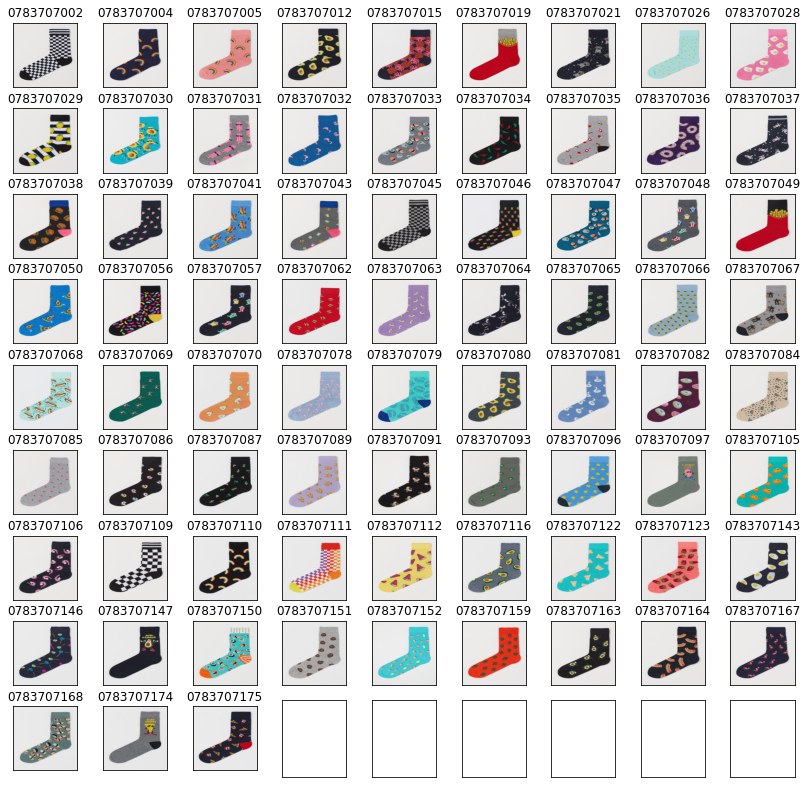

In [104]:
fig, axes = plt.subplots(9, 9, figsize=(14, 14),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.4))

for i, ax in enumerate(axes.flat):
    ax.imshow(Image.open(files_0783707[i]).resize((180, 180)))
    ax.set_title(files_0783707[i][56:-4]) 
    if i == len(files_0783707)-1:
        break

### What is the breakdown of `index_name`?

In [27]:
%%bigquery
SELECT DISTINCT index_name,index_group_name AS occurences
FROM h_and_m.articles
WHERE index_name != index_group_name

Downloading: 100%|██████████| 6/6 [00:01<00:00,  5.61rows/s]


index_name     occurences
0          Children Sizes 134-170  Baby/Children
1           Children Sizes 92-140  Baby/Children
2                Lingeries/Tights     Ladieswear
3              Ladies Accessories     Ladieswear
4                Baby Sizes 50-98  Baby/Children
5  Children Accessories, Swimwear  Baby/Children

### What is the breakdown of `index_group_name`?

In [31]:
%%bigquery
SELECT index_name, COUNT(index_name) AS occurences
FROM h_and_m.articles
GROUP BY index_name
ORDER BY occurences DESC

Downloading: 100%|██████████| 10/10 [00:01<00:00,  9.06rows/s]


index_name  occurences
0                      Ladieswear       26001
1                         Divided       15149
2                        Menswear       12553
3           Children Sizes 92-140       12007
4          Children Sizes 134-170        9214
5                Baby Sizes 50-98        8875
6              Ladies Accessories        6961
7                Lingeries/Tights        6775
8  Children Accessories, Swimwear        4615
9                           Sport        3392

In [36]:
%%bigquery
SELECT 
    index_group_name, 
    STRING_AGG(DISTINCT index_name) AS distinct_index_names,
    STRING_AGG(DISTINCT garment_group_name) AS distinct_garments
FROM h_and_m.articles
GROUP BY index_group_name

Downloading: 100%|██████████| 5/5 [00:02<00:00,  1.89rows/s]


index_group_name                               distinct_index_names  \
0         Menswear                                           Menswear   
1          Divided                                            Divided   
2       Ladieswear     Ladieswear,Lingeries/Tights,Ladies Accessories   
3    Baby/Children  Children Sizes 134-170,Children Sizes 92-140,B...   
4            Sport                                              Sport   

                                   distinct_garments  
0  Swimwear,Accessories,Under-, Nightwear,Dressed...  
1  Blouses,Dresses Ladies,Unknown,Outdoor,Jersey ...  
2  Unknown,Special Offers,Socks and Tights,Dresse...  
3  Dresses/Skirts girls,Jersey Fancy,Trousers,Kni...  
4  Outdoor,Jersey Fancy,Accessories,Unknown,Trousers

## Exploring the `customers` table

In [2]:
%%bigquery
SELECT * FROM h_and_m.customers LIMIT 3

Downloading: 100%|██████████| 3/3 [00:01<00:00,  2.45rows/s]


customer_id   FN  Active  \
0  09a3dd9b174ce39cdfe1e8b5ec47167c8cc604928eec20...  1.0     1.0   
1  1608504257feb3b38b3700a081e12d2b1901c9b7d9be6d...  1.0     1.0   
2  1e033264a3b552fe88bdcce44174dff8b4cfc58dad529c...  1.0     1.0   

  club_member_status fashion_news_frequency  age  \
0         PRE-CREATE                Monthly   65   
1         PRE-CREATE                Monthly   66   
2             ACTIVE                Monthly   77   

                                         postal_code  
0  b97439bfd3a833f9ef16537af6693c07493646d57b6191...  
1  8fc2e6694f5b0fe6bcd212965cd9024e333e6c65473caf...  
2  2df2189d6fefc69255504d4640f44adc849bd899bc2a3c...

What is the age demographic of the customers?

In [37]:
%%bigquery
SELECT 
    age, COUNT(DISTINCT customer_id) AS number_of_cust
FROM
    h_and_m.customers
GROUP BY
    age
ORDER BY
    number_of_cust DESC

Downloading: 100%|██████████| 85/85 [00:01<00:00, 75.38rows/s] 


age  number_of_cust
0   21.0           67530
1   24.0           56124
2   20.0           55196
3   25.0           54989
4   23.0           54867
..   ...             ...
80  98.0               7
81  93.0               4
82  97.0               4
83  96.0               3
84  94.0               3

[85 rows x 2 columns]

## Exploring the `transactions` table

In [8]:
%%bigquery
SELECT * FROM h_and_m.transactions_sample LIMIT 3

Downloading: 100%|██████████| 3/3 [00:01<00:00,  2.07rows/s]


t_dat                                        customer_id  article_id  \
0  2019-01-24  02354fba443ecfd9914e9f842fe8a61e7e367cf6dd7057...   189616001   
1  2019-01-24  02354fba443ecfd9914e9f842fe8a61e7e367cf6dd7057...   571706001   
2  2019-01-24  02354fba443ecfd9914e9f842fe8a61e7e367cf6dd7057...   571706001   

      price  sales_channel_id  
0  0.016932                 2  
1  0.022017                 2  
2  0.022017                 2

What is the date range of the `transactions` table?

Top 10 customers by num of transactions:

Top 10 customers by revenue:

What are the top 5 `product_code` and `product_type_name`?

How about `product_group_name`?